In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sys
import pickle
import string

import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.cross_validation import KFold, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier

### Task 1: Select what features you'll use.

In [2]:
### features_list is a list of strings, each of which is a feature name.
features_list = ['poi','salary', 'deferral_payments', 'total_payments', 'loan_advances',\
    'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value',\
    'expenses', 'exercised_stock_options', 'other', 'long_term_incentive',\
    'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person',\
    'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

### Load the dictionary containing the dataset, create DataFrame from dictionary
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Task 2: Remove outliers

In [3]:
data_dict.pop('TOTAL', 0)
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', 0) # from reading the pdf

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

### Task 3: Create new feature(s)

In [4]:
def compute_ratio(numerator, denominator, ratio_list):
    for name in data_dict:
        if data_dict[name][denominator] == 'NaN' or data_dict[name][denominator] == 0 \
        or data_dict[name][numerator] == 'NaN':
            data_dict[name][ratio_list] = 0
        if data_dict[name][denominator] != 'NaN' and data_dict[name][denominator] != 0 \
        and data_dict[name][numerator] != 'NaN':
            ratio = data_dict[name][numerator] / float(data_dict[name][denominator])
            data_dict[name][ratio_list] = ratio
        else:
            data_dict[name][ratio_list] = 'NaN'
    print "New feature", ratio_list, "is added to data_dict."

compute_ratio('from_this_person_to_poi', 'to_messages', 'ratio_to_poi')
compute_ratio('from_poi_to_this_person', 'from_messages', 'ratio_from_poi') 
compute_ratio('bonus', 'salary', 'ratio_bonus_to_salary')
features_list.extend(('ratio_to_poi', 'ratio_from_poi', 'ratio_bonus_to_salary'))

New feature ratio_to_poi is added to data_dict.
New feature ratio_from_poi is added to data_dict.
New feature ratio_bonus_to_salary is added to data_dict.


In [5]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, remove_NaN=True, remove_all_zeroes=True, sort_keys=True)
labels, features = targetFeatureSplit(data)

### Task 4: Try a varity of classifiers

In [14]:
### Feature selection by SelectKBest
skb = SelectKBest()
fit = skb.fit(features, labels)
temp = features_list[1:]
d = {'features': temp, 'scores': fit.scores_}
scores_df = pd.DataFrame(d).sort_values(by='scores', ascending=False)
scores_df

,features,scores
9,exercised_stock_options,24.815080
7,total_stock_value,24.182899
4,bonus,20.792252
0,salary,18.289684
6,deferred_income,11.458477
21,ratio_bonus_to_salary,10.783585
11,long_term_incentive,9.922186
12,restricted_stock,9.212811
2,total_payments,8.772778
18,shared_receipt_with_poi,8.589421


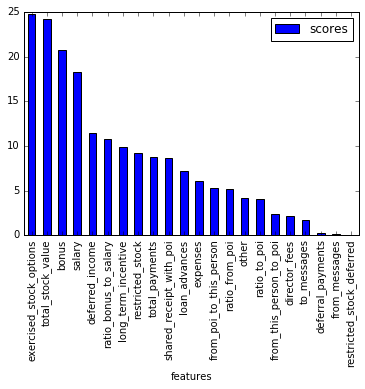

In [15]:
scores_df.plot.bar(x='features')

In [43]:
features_selected = ['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'salary']
data = featureFormat(my_dataset, features_selected, remove_NaN=True, remove_all_zeroes=True, sort_keys=True, remove_any_zeroes=True)
labels, features = targetFeatureSplit(data)
sss = StratifiedShuffleSplit(labels, n_iter=100, train_size=0.75, random_state=46)

In [41]:
### Try decision tree
tree = DecisionTreeClassifier()
params = {'min_samples_split': range(5, 41, 5),
         'class_weight': ['balanced', {True: 10, False: 1}, {True: 8, False: 1}, {True: 6, False: 1}],
         'splitter': ['random', 'best']
         }
gs = GridSearchCV(tree, param_grid=params, scoring='precision', cv=sss)
gs.fit(features, labels)
tree_estimator = gs.best_estimator_
print "Best Estimator: ", tree_estimator
print "Best Params: ", gs.best_params_
test_classifier(tree_estimator, my_dataset, features_list, folds = 1000)

Best Estimator:  DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=25,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')
Best Params:  {'min_samples_split': 25, 'splitter': 'random', 'class_weight': 'balanced'}
DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=25,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')
	Accuracy: 0.68786	Precision: 0.24411	Recall: 0.59500	F1: 0.34619	F2: 0.46214
	Total predictions: 36000	True positives: 2975	False positives: 9212	False negatives: 2025	True negatives: 21788



In [46]:
### Try SVM
svc = SVC()
scaler = MinMaxScaler()
pipe = Pipeline([('scaler', scaler), ('svc', svc)])
params = {'svc__kernel':['rbf', 'linear'], 
          'svc__degree': range(1, 3),
          'svc__C': range(8, 25, 2),
          'svc__class_weight': [{True: 14, False: 1}, {True: 12, False: 1}, {True: 10, False: 1}]
          }
gs = GridSearchCV(pipe, param_grid=params, scoring='precision', cv=sss)
gs.fit(features, labels)
svc_estimator = gs.best_estimator_
print "Best Estimator: ", svc_estimator
print "Best Params: ", gs.best_params_
test_classifier(svc_estimator, my_dataset, features_selected, folds = 1000)

Best Estimator:  Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=8, cache_size=200, class_weight={False: 1, True: 12}, coef0=0.0,
  decision_function_shape=None, degree=1, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
Best Params:  {'svc__class_weight': {False: 1, True: 12}, 'svc__degree': 1, 'svc__kernel': 'linear', 'svc__C': 8}
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=8, cache_size=200, class_weight={False: 1, True: 12}, coef0=0.0,
  decision_function_shape=None, degree=1, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.49442	Precision: 0.21922	Recall: 0.91220	F1: 0.35348	F2: 0.55886
	Total predictions: 33000	True positives: 4561	False positives: 16245	False negatives:  439	True negatives: 11755



### Task 5: Tune your classifier to achieve better than .3 precision and recall 

In [45]:
scaler = MinMaxScaler()
knn = KNeighborsClassifier()
pipeline = Pipeline([('scaler', scaler), ('knn', knn)])
params = {'knn__n_neighbors': range(1, 10),
          'knn__weights': ['uniform', 'distance'],
          'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
          }
gs = GridSearchCV(pipeline, param_grid=params, scoring='f1', cv=sss)
gs.fit(features, labels)
knn_estimator = gs.best_estimator_
print "Best Estimator: ", knn_estimator
print "Best Params: ", gs.best_params_
test_classifier(knn_estimator, my_dataset, features_selected, folds = 1000)

Best Estimator:  Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])
Best Params:  {'knn__algorithm': 'auto', 'knn__weights': 'uniform', 'knn__n_neighbors': 1}
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])
	Accuracy: 0.79842	Precision: 0.32727	Recall: 0.31300	F1: 0.31998	F2: 0.31575
	Total predictions: 33000	True positives: 1565	False positives: 3217	False negatives: 3435	True negatives: 24783



In [47]:
### Re-testing the best knn classifier
clf = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=1, p=2, weights='uniform')
test_classifier(clf, my_dataset, features_selected, folds = 1000)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
	Accuracy: 0.83982	Precision: 0.46266	Recall: 0.35440	F1: 0.40136	F2: 0.37180
	Total predictions: 33000	True positives: 1772	False positives: 2058	False negatives: 3228	True negatives: 25942



### Task 5.5: Test one of the newly implemented features

In [50]:
### Adding the new feature ratio_bonus_to_salary to the data
features_test = ['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 'ratio_bonus_to_salary']

clf_test = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=1, p=2, weights='uniform')
test_classifier(clf_test, my_dataset, features_test, folds = 1000)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
	Accuracy: 0.83982	Precision: 0.46266	Recall: 0.35440	F1: 0.40136	F2: 0.37180
	Total predictions: 33000	True positives: 1772	False positives: 2058	False negatives: 3228	True negatives: 25942



### Task 6: Dump your classifier, dataset, and features_list so anyone can check your results. 

In [51]:
dump_classifier_and_data(clf, my_dataset, features_selected)